# rvjenya - tiny ML classifier - Glasses or No Glasses Image for TFLite

## Setup

**Connect to my Google Drive**



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive

Mounted at /content/gdrive


**Import lib for my working**

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.6.0
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## TF2 SavedModel module to use

In [3]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


## Set up my dataset 

In [4]:
#set variables
data_dir = 'images' 
base_path = '/content/gdrive/MyDrive/2021/datasets'
imagezipped = 'data.zip'
epochs = 10

In [5]:
#first of all, we need to delete any images or saved model from the previous run, if any.
os.system("rm -rf {data_dir}".format(data_dir=data_dir))
# !rm -rf images
!rm -rf /tmp/saved_model

In [6]:
#create output path if not yet existing
os.system("mkdir {base_path}/output".format(base_path=base_path))

256

In [7]:
#unzipped images into session storage
os.system("unzip -o {base_path}/{imagezipped}  -d .".format(base_path=base_path,imagezipped=imagezipped))

0

In [10]:
data_dir = '/content/data/images' 

Some augmentation dataset

In [11]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 983 images belonging to 2 classes.
Found 3937 images belonging to 2 classes.


## Defining the model (it just will be full .pb model)

In [12]:
do_fine_tuning = True #@param {type:"boolean"}

In [13]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


## And Start Training (I hope 10 epoch will be enough)

In [14]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/10
123/123 [==============================] - 200s 1s/step - loss: 0.3604 - accuracy: 0.9716 - val_loss: 0.7072 - val_accuracy: 0.8000
Epoch 2/10
123/123 [==============================] - 162s 1s/step - loss: 0.3115 - accuracy: 0.9944 - val_loss: 0.3797 - val_accuracy: 0.9958
Epoch 3/10
123/123 [==============================] - 162s 1s/step - loss: 0.2948 - accuracy: 0.9980 - val_loss: 0.2933 - val_accuracy: 1.0000
Epoch 4/10
123/123 [==============================] - 162s 1s/step - loss: 0.3278 - accuracy: 0.9862 - val_loss: 0.3891 - val_accuracy: 0.9781
Epoch 5/10
123/123 [==============================] - 163s 1s/step - loss: 0.2996 - accuracy: 0.9985 - val_loss: 0.2901 - val_accuracy: 0.9969
Epoch 6/10
123/123 [==============================] - 162s 1s/step - loss: 0.2950 - accuracy: 0.9980 - val_loss: 0.2906 - val_accuracy: 0.9979
Epoch 7/10
123/123 [==============================] - 161s 1s/step - loss: 0.2934 - accuracy: 0.9977 - val_loss: 0.2876 - val_accuracy: 1.0000

## Show results

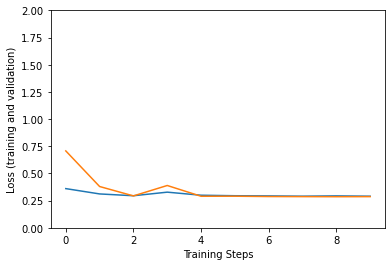

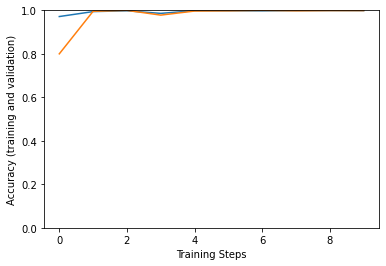

In [16]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Try out the model on an image from the validation data:

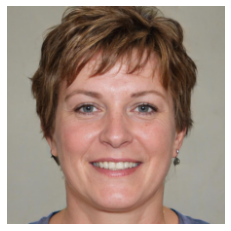

True label: no_glasses
Predicted label: no_glasses


In [35]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[1, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()


prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

Finally, the trained model can be created as SavedModel format on  my GDrive.

In [42]:
# create saved_model in session storage
saved_model_path = "/content/gdrive/MyDrive/2021/datasets/output/tmp/saved_model" 
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/2021/datasets/output/tmp/saved_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/2021/datasets/output/tmp/saved_model/assets


## Convert a SavedModel to TFLite files

Create model.tflite and labels.txt. 

In [41]:
#@title Optimization settings
# docs_infra: no_execute
# TODO(b/156102192)
optimize_lite_model = True  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 200  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

#tflitepath = "{base_path}/output/model.tflite".format(base_path=base_path)
tflitepath = "{base_path}/output/model_num_calib200.tflite".format(base_path=base_path)
with open(tflitepath, "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote optimized TFLite model of 2715240 bytes.


In [39]:
#create labels.txt
labels = tuple(sorted(os.listdir(data_dir))) 
labels_output_file = "{base_path}/output/labels.txt".format(base_path=base_path)
if labels_output_file:
  with tf.io.gfile.GFile(labels_output_file, "w") as f:
    f.write("\n".join(labels + ("",)))
  print("Labels written to", labels_output_file)

Labels written to /content/gdrive/MyDrive/2021/datasets/output/labels.txt


## Go to next task --->> create infer demo and deployment to RPi